In [1]:
from pyscf import gto, scf, lo, tools, fci, ao2mo, mcscf, df

from openfermion import MolecularData

from openfermionpyscf import run_pyscf, compute_integrals
from openfermionpyscf import prepare_pyscf_molecule
import module as md
from openfermion.transforms import get_fermion_operator, jordan_wigner,\
    bravyi_kitaev, bravyi_kitaev_fast, get_interaction_operator, JW1norm
# from tqdm import tqdm
import numpy as np

In [2]:
# Set molecule parameters.
basis = ['sto-3g', 'cc-pvdz'][1]
multiplicity = 1
# Set calculation parameters.
consider_cas = 0
run_scf = 1
run_mp2 = 0
run_cisd = 0
run_ccsd = 0
run_fci = 0
run_casci = 0
n_orbitals = 4
n_electrons = 4
verbose = 1
localize = 0
visualize = 0
localizemethod = ['Boys','Pipek-Mezey','ibo','ER'][1]
localize_virt = 0 # Choose whether you want to localize the virtual MO's
if consider_cas:
    localize_cas = 1 # Localize only in the CAS
    only_cas = 1 # Store only the CAS integrals in the molecule object
else:
    localize_cas = 0
    only_cas = 0 

localize_sep = 0
do_svd = 0
also_h1e = 0
do_cholesky = 0
Orth_AO = 0
# delete_input = True
# delete_output = True
save_tohdf5 = 0
max_memory = 8000
H_chain = 0
H_ring = 0
    
fname = ['xyz_files/H2nosym.txt','xyz_files/H2COnosym.txt','xyz_files/H10.txt',\
         'xyz_files/C2.txt', 'xyz_files/LiH.txt', 'xyz_files/HLiO.txt', \
         'xyz_files/H2Onosym.txt', 'xyz_files/H14.txt', \
         'xyz_files/hnch2_s0min_dzp.txt', 'xyz_files/hnc3h6_s0min_dzp.txt',\
         'xyz_files/hnc5h10_s0min_dzp.txt', 'xyz_files/hnc7h14_s0min_dzp.txt',\
         'xyz_files/benzene.txt','xyz_files/PCy3.txt','xyz_files/PCy3Cl2Ru.txt'][9]
geometry = md.xyz_to_geom(fname)
if run_fci:
    description = fname.replace('xyz_files/','').replace('.txt','') +\
        str(basis) + 'FCI'
elif run_casci or consider_cas:
    description = fname.replace('xyz_files/','').replace('.txt','') + str(basis)\
        + 'ne' + str(n_electrons) + 'no' + str(n_orbitals)
else:
    description = fname.replace('xyz_files/','').replace('.txt','') + str(basis)
if do_cholesky:
    description += 'chol'

#description += localizemethod
nao = md.count_ao(geometry, basis)
nelec = md.count_elec(geometry,basis)
ndocc = nelec // 2
print('Molecule we are considering is:',geometry)
print('Number of AOs:', nao)
print('Number of electrons:', nelec)
print('\n')


threshold = 1e-10

print('Considering', n_electrons, 'electrons in', n_orbitals, 'orbitals')

localize = 0
localize_virt = 0 

molecule = MolecularData(
    geometry, basis, multiplicity,
    description=description)

mol = prepare_pyscf_molecule(molecule)

myhf = scf.RHF(mol)
myhf.run()

Molecule we are considering is: [('N', (-0.50747536, 0.23273591, -0.35428162)), ('C', (0.15806969, -0.39299294, 0.52445166)), ('H', (-0.41667784, -0.93344006, 1.28336632)), ('H', (0.12146052, 0.69990131, -1.01477401)), ('C', (2.11822521, -1.96552995, 0.59759654)), ('C', (1.64960563, -0.5076048, 0.65409196)), ('H', (3.19650489, -2.03195618, 0.74332017)), ('H', (1.87325068, -2.41217037, -0.36712064)), ('H', (1.63694049, -2.56122942, 1.37568217)), ('H', (2.13235514, 0.08285087, -0.13035969)), ('H', (1.94444664, -0.0707152, 1.61535508))]
Number of AOs: 91
Number of electrons: 32


Considering 4 electrons in 4 orbitals
converged SCF energy = -172.122995610985


In [3]:
C_nonloc = myhf.mo_coeff
S = myhf.get_ovlp()
S_eigval, S_eigvec = np.linalg.eigh(S)
S_sqrt_inv = S_eigvec @ np.diag((S_eigval)**(-1./2.)) @ np.linalg.inv(S_eigvec)
S_sqrt = S_eigvec @ np.diag((S_eigval)**(1./2.)) @ np.linalg.inv(S_eigvec)

In [4]:
Proj = np.zeros((nao,nao))
for p in range(nao):
    for r in range(nao):
        Proj[p,r] = np.abs((C_nonloc.T @ S_sqrt)[p,r]) ** 2
    

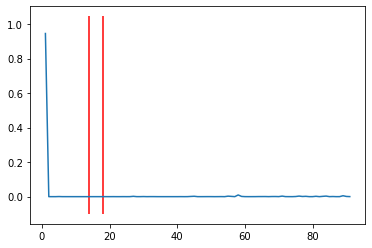

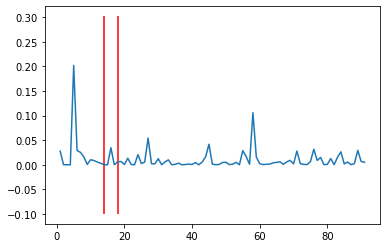

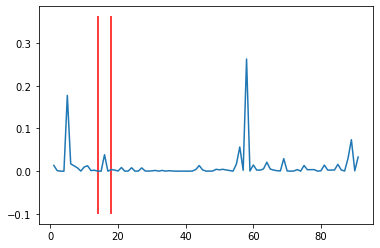

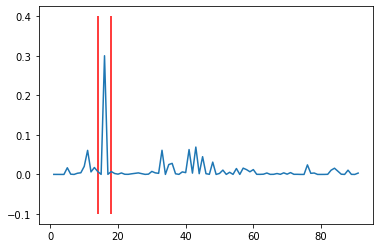

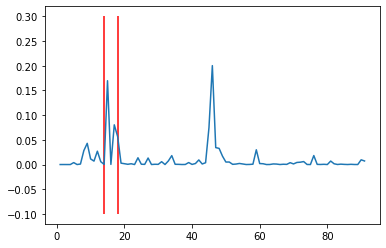

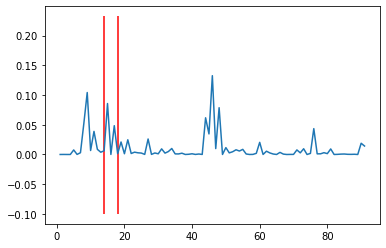

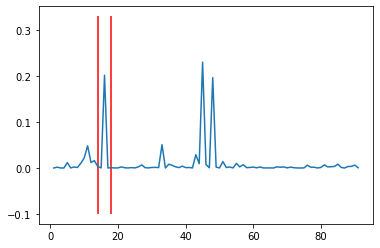

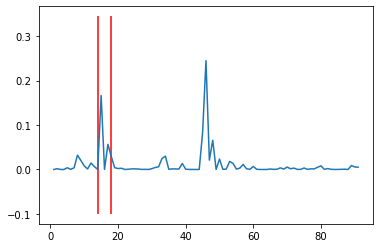

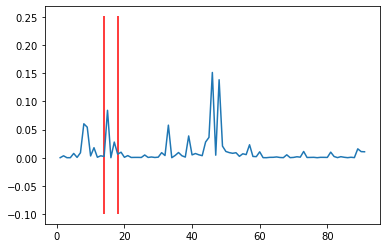

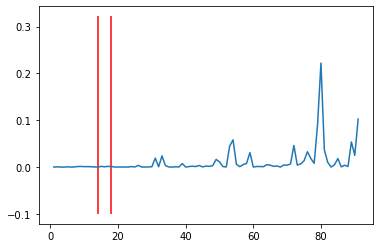

In [5]:
import matplotlib.pyplot as plt

x = np.array(np.arange(1,nao+1))

for r in range(10):
    y_0 = []
    for p in range(nao):
        y_0.append(Proj[p,r])
    plt.figure()
    plt.vlines([ndocc-(n_orbitals//2),ndocc + (n_orbitals//2)],min(y_0)-0.1, max(y_0)+0.1, colors='red')
    plt.plot(x,y_0)
plt.show()

In [6]:
sum_proj_act = np.zeros((nao,))
for r in range(nao):
    sum_proj_act[r] = np.sum(Proj[ndocc-(n_orbitals//2):ndocc + (n_orbitals//2),r])
print(sum_proj_act)

[7.72147767e-05 4.07009846e-02 4.22754909e-02 3.08275184e-01
 3.06992863e-01 1.35546859e-01 2.02691551e-01 2.52392339e-01
 1.18426229e-01 4.67915583e-03 4.24062281e-03 9.24948383e-03
 2.41612835e-03 2.98255424e-03 1.05662865e-04 2.53328435e-03
 3.95167602e-03 7.12040122e-02 2.26754059e-01 1.23621302e-01
 7.47297999e-04 2.17600389e-01 1.15567560e-01 1.85491792e-02
 1.39534262e-02 3.59494186e-02 1.68419930e-02 2.84606062e-02
 4.76716935e-02 1.85891642e-02 5.40676822e-04 1.95808256e-02
 7.27095921e-03 5.01656195e-02 1.41894730e-01 1.90357642e-02
 1.65883422e-02 2.36089693e-02 5.19923258e-04 5.16176672e-02
 2.75014671e-02 1.66912113e-02 3.87800828e-02 2.54497003e-03
 7.10678217e-03 1.52360100e-02 5.19642978e-04 1.75089954e-03
 9.97490715e-04 5.74296186e-03 1.00745939e-03 9.76815212e-03
 4.91047071e-04 4.41317504e-02 2.64320731e-02 9.40079073e-02
 4.18694414e-02 1.84776488e-02 2.42648052e-02 6.19895046e-03
 4.40136852e-03 2.35375629e-02 2.76891483e-03 1.04234497e-02
 1.39784377e-02 7.027584

In [7]:
active_OAO = sum_proj_act.argsort()[::-1][:n_orbitals]

In [8]:
active_OAO

array([ 3,  4,  7, 18])

In [9]:
sum_proj_act[active_OAO]

array([0.30827518, 0.30699286, 0.25239234, 0.22675406])

In [10]:
sum_proj_occ = np.zeros((nao,))
for r in range(nao):
    sum_proj_occ[r] = np.sum(Proj[:ndocc,r])
print(sum_proj_occ)

[0.94580415 0.36262837 0.29428735 0.43796563 0.29743092 0.31708878
 0.33082437 0.25934564 0.24648367 0.00868008 0.00713412 0.00535902
 0.01466353 0.00375099 0.93690762 0.29643551 0.18942757 0.33141568
 0.25405915 0.29516354 0.18251427 0.18714069 0.18454262 0.028414
 0.02023345 0.02904923 0.04124886 0.02955731 0.31844169 0.1345847
 0.01283244 0.01064958 0.01470573 0.30119638 0.11357222 0.02896608
 0.01781541 0.02220885 0.93678015 0.27368657 0.18708152 0.30616308
 0.30374107 0.30630015 0.21420715 0.19496777 0.21911017 0.01274371
 0.02164985 0.01607159 0.00733722 0.02314297 0.93817012 0.27566981
 0.18391788 0.31194634 0.31036729 0.30722088 0.19161077 0.19626477
 0.211346   0.01899533 0.02162506 0.01796927 0.01482238 0.02839376
 0.31556548 0.13187211 0.02357267 0.00796129 0.00821571 0.31572805
 0.13226805 0.00863784 0.0106109  0.02051488 0.31566422 0.13295339
 0.01096595 0.01274369 0.01596614 0.31729895 0.13235258 0.01080246
 0.01249495 0.01591147 0.3152143  0.12917047 0.00912131 0.0106257

In [11]:
occ_OAO = sum_proj_occ.argsort()[::-1][:(ndocc-(n_orbitals//2))]

In [12]:
occ_OAO

array([ 0, 52, 14, 38,  3,  1, 17,  6, 28, 81,  5, 71, 76, 66])

In [13]:
sum_proj_occ[occ_OAO]

array([0.94580415, 0.93817012, 0.93690762, 0.93678015, 0.43796563,
       0.36262837, 0.33141568, 0.33082437, 0.31844169, 0.31729895,
       0.31708878, 0.31572805, 0.31566422, 0.31556548])

In [14]:
13 in occ_OAO

False

In [15]:
counter = 0
for i in range(len(active_OAO)):
    for j in range(len(occ_OAO)):
        if active_OAO[i] == occ_OAO[j]:
            print("ERROR! Index", active_OAO[i], "is found in both active and occupied OAO indices!")
            print("\nRemoving index from active_OAO....")
            active_OAO[i] = sum_proj_act.argsort()[::-1][n_orbitals+counter]
            counter += 1
            print("Done removing index from active_OAO. New active indices are:", active_OAO)
print(sum_proj_act[active_OAO], active_OAO)
    

ERROR! Index 3 is found in both active and occupied OAO indices!

Removing index from active_OAO....
Done removing index from active_OAO. New active indices are: [21  4  7 18]
[0.21760039 0.30699286 0.25239234 0.22675406] [21  4  7 18]


In [16]:
import time
t0 = time.time()
Orth_AO = 1
# Run pyscf.
molecule = run_pyscf(molecule,
                     threshold=threshold,
                     also_h1e=also_h1e,
                     run_scf=run_scf,
                     run_mp2=run_mp2,
                     run_cisd=run_cisd,
                     run_ccsd=run_ccsd,
                     run_fci=run_fci,
                     run_casci=run_casci,
                     n_electrons=n_electrons,
                     n_orbitals=n_orbitals,
                     verbose=verbose,
                     localize=localize,
                     visualize=visualize,
                     localizemethod=localizemethod,
                     localize_virt=localize_virt,
                     localize_cas=localize_cas,
                     only_cas=only_cas,
                     localize_sep=localize_sep,
                     do_cholesky=do_cholesky,
                     do_svd=do_svd,
                     Orth_AO=Orth_AO,
                     save_tohdf5=save_tohdf5,
                     max_memory=max_memory)
print('run_pyscf took', time.time() - t0)

Doing HF took 0.26456189155578613
Computing inverse overlap took 0.00142669677734375
localizing took 0.0015704631805419922
Hartree-Fock energy for H7-C3-N1_cc-pvdz_singlet_hnc3h6_s0min_dzpcc-pvdz (32 electrons) is -172.1229956109849.
populating data fields in molecule class took 7.3909759521484375e-06
computing integrals and storing them took 1.016258955001831
saving data to molecular data structure took 1.3828277587890625e-05
run_pyscf took 1.3454985618591309


In [17]:
molecular_hamiltonian = molecule.get_molecular_hamiltonian(occupied_indices=occ_OAO, active_indices=active_OAO)

In [18]:
from openfermion.linalg import LinearQubitOperator

lin_op_H = LinearQubitOperator(jordan_wigner(molecular_hamiltonian))

pooling took 0.03288912773132324 seconds
closing pools took 2.6226043701171875e-06
adding twobody terms to total took 0.0037071704864501953
twobody transformation took 0.21726441383361816


In [19]:
import scipy 

w, v = scipy.sparse.linalg.eigsh(lin_op_H)

In [21]:
print("zeroth eigenvalue doing CASCI in OAO space is:",w[0])

zeroth eigenvalue doing CASCI in OAO space is: -133.9475982871055


In [20]:
# Set molecule parameters.
basis = ['sto-3g', 'cc-pvdz'][1]
multiplicity = 1
# Set calculation parameters.
consider_cas = 0
run_scf = 1
run_mp2 = 0
run_cisd = 0
run_ccsd = 0
run_fci = 0
run_casci = 1
n_orbitals = 4
n_electrons = 4
verbose = 1
localize = 0
visualize = 0
localizemethod = ['Boys','Pipek-Mezey','ibo','ER'][1]
localize_virt = 0 # Choose whether you want to localize the virtual MO's
if consider_cas:
    localize_cas = 1 # Localize only in the CAS
    only_cas = 1 # Store only the CAS integrals in the molecule object
else:
    localize_cas = 0
    only_cas = 0 

localize_sep = 0
do_svd = 0
also_h1e = 0
do_cholesky = 0
Orth_AO = 0
# delete_input = True
# delete_output = True
save_tohdf5 = 0
max_memory = 8000
H_chain = 0
H_ring = 0
    
fname = ['xyz_files/H2nosym.txt','xyz_files/H2COnosym.txt','xyz_files/H10.txt',\
         'xyz_files/C2.txt', 'xyz_files/LiH.txt', 'xyz_files/HLiO.txt', \
         'xyz_files/H2Onosym.txt', 'xyz_files/H14.txt', \
         'xyz_files/hnch2_s0min_dzp.txt', 'xyz_files/hnc3h6_s0min_dzp.txt',\
         'xyz_files/hnc5h10_s0min_dzp.txt', 'xyz_files/hnc7h14_s0min_dzp.txt',\
         'xyz_files/benzene.txt','xyz_files/PCy3.txt','xyz_files/PCy3Cl2Ru.txt'][9]
geometry = md.xyz_to_geom(fname)
if run_fci:
    description = fname.replace('xyz_files/','').replace('.txt','') +\
        str(basis) + 'FCI'
elif run_casci or consider_cas:
    description = fname.replace('xyz_files/','').replace('.txt','') + str(basis)\
        + 'ne' + str(n_electrons) + 'no' + str(n_orbitals)
else:
    description = fname.replace('xyz_files/','').replace('.txt','') + str(basis)
if do_cholesky:
    description += 'chol'

#description += localizemethod
nao = md.count_ao(geometry, basis)
nelec = md.count_elec(geometry,basis)
ndocc = nelec // 2
print('Molecule we are considering is:',geometry)
print('Number of AOs:', nao)
print('Number of electrons:', nelec)
print('\n')


threshold = 1e-10

print('Considering', n_electrons, 'electrons in', n_orbitals, 'orbitals')

localize = 0
localize_virt = 0 

molecule = MolecularData(
    geometry, basis, multiplicity,
    description=description)
t0 = time.time()


# Run pyscf.
molecule = run_pyscf(molecule,
                     threshold=threshold,
                     also_h1e=also_h1e,
                     run_scf=run_scf,
                     run_mp2=run_mp2,
                     run_cisd=run_cisd,
                     run_ccsd=run_ccsd,
                     run_fci=run_fci,
                     run_casci=run_casci,
                     n_electrons=n_electrons,
                     n_orbitals=n_orbitals,
                     verbose=verbose,
                     localize=localize,
                     visualize=visualize,
                     localizemethod=localizemethod,
                     localize_virt=localize_virt,
                     localize_cas=localize_cas,
                     only_cas=only_cas,
                     localize_sep=localize_sep,
                     do_cholesky=do_cholesky,
                     do_svd=do_svd,
                     Orth_AO=Orth_AO,
                     save_tohdf5=save_tohdf5,
                     max_memory=max_memory)
print('run_pyscf took', time.time() - t0)

Molecule we are considering is: [('N', (-0.50747536, 0.23273591, -0.35428162)), ('C', (0.15806969, -0.39299294, 0.52445166)), ('H', (-0.41667784, -0.93344006, 1.28336632)), ('H', (0.12146052, 0.69990131, -1.01477401)), ('C', (2.11822521, -1.96552995, 0.59759654)), ('C', (1.64960563, -0.5076048, 0.65409196)), ('H', (3.19650489, -2.03195618, 0.74332017)), ('H', (1.87325068, -2.41217037, -0.36712064)), ('H', (1.63694049, -2.56122942, 1.37568217)), ('H', (2.13235514, 0.08285087, -0.13035969)), ('H', (1.94444664, -0.0707152, 1.61535508))]
Number of AOs: 91
Number of electrons: 32


Considering 4 electrons in 4 orbitals
Doing HF took 0.2720677852630615
localizing took 4.76837158203125e-07
Hartree-Fock energy for H7-C3-N1_cc-pvdz_singlet_hnc3h6_s0min_dzpcc-pvdzne4no4 (32 electrons) is -172.1229956109865.
populating data fields in molecule class took 9.298324584960938e-06
computing integrals and storing them took 1.0849027633666992
Computing CASCI(4,4)
ncore 14 ncas 4 nocc 18
extracting cas in